In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.misc import imread

import maxflow
# https://github.com/pmneila/PyMaxflow

from skimage.morphology import remove_small_holes, remove_small_objects

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import sys, os
sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from registration_utilities import find_contour_points

Setting environment for Gordon


No vtk


In [5]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [10]:
train_sample_scheme = 1

In [11]:
stack = 'MD635'
anchor_fn = DataManager.load_anchor_filename(stack=stack)
first_sec, last_sec = metadata_cache['section_limits'][stack]
sec2fn = metadata_cache['sections_to_filenames'][stack]

In [12]:
name_sided = '7N_L'

xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_volume_bbox(stack=stack, type='score', label=convert_name_to_unsided(name_sided), downscale=32)

vol = DataManager.load_transformed_volume(stack_m='atlasV2', type_m='score', stack_f=stack, type_f='score', downscale=32,
                                   train_sample_scheme_f=train_sample_scheme, global_transform_scheme=1, local_transform_scheme=2,
                                   label=name_sided, transitive='over')

In [13]:
FITTED_CONTOUR_DIR = create_if_not_exists('/home/yuncong/csd395/CSHL_snakeViz/%(stack)s/%(name_sided)s' % \
                                 dict(stack=stack, name_sided=name_sided))

In [14]:
xmin, xmax, ymin, ymax, zmin, zmax = bbox_3d(vol)
print 'Structure bnounding box:', xmin, xmax, ymin, ymax, zmin, zmax

sec_min = DataManager.convert_z_to_section(stack=stack, z=zmin, downsample=32)
sec_max = DataManager.convert_z_to_section(stack=stack, z=zmax, downsample=32)
print sec_min, sec_max

Structure bnounding box: 252 309 312 357 81 149
134 184


147


/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


235 329 292 362


/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (298470400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


3008 2240


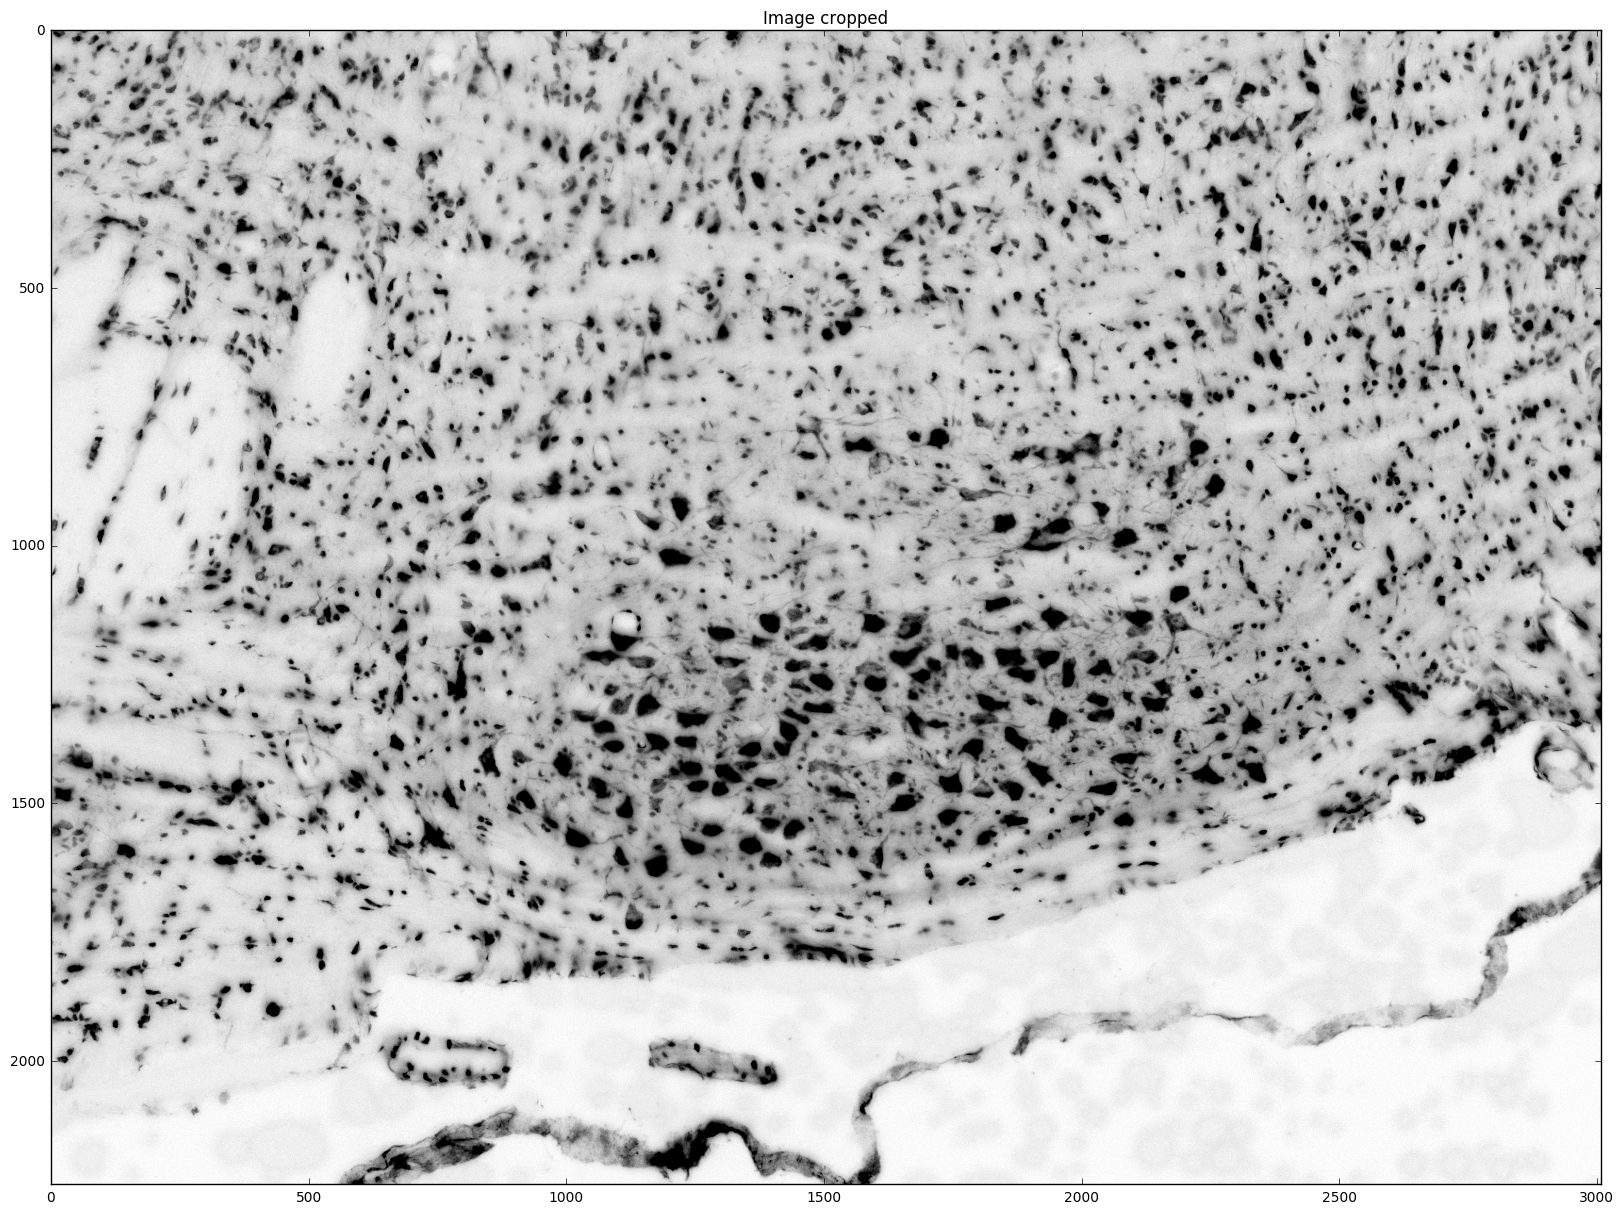

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


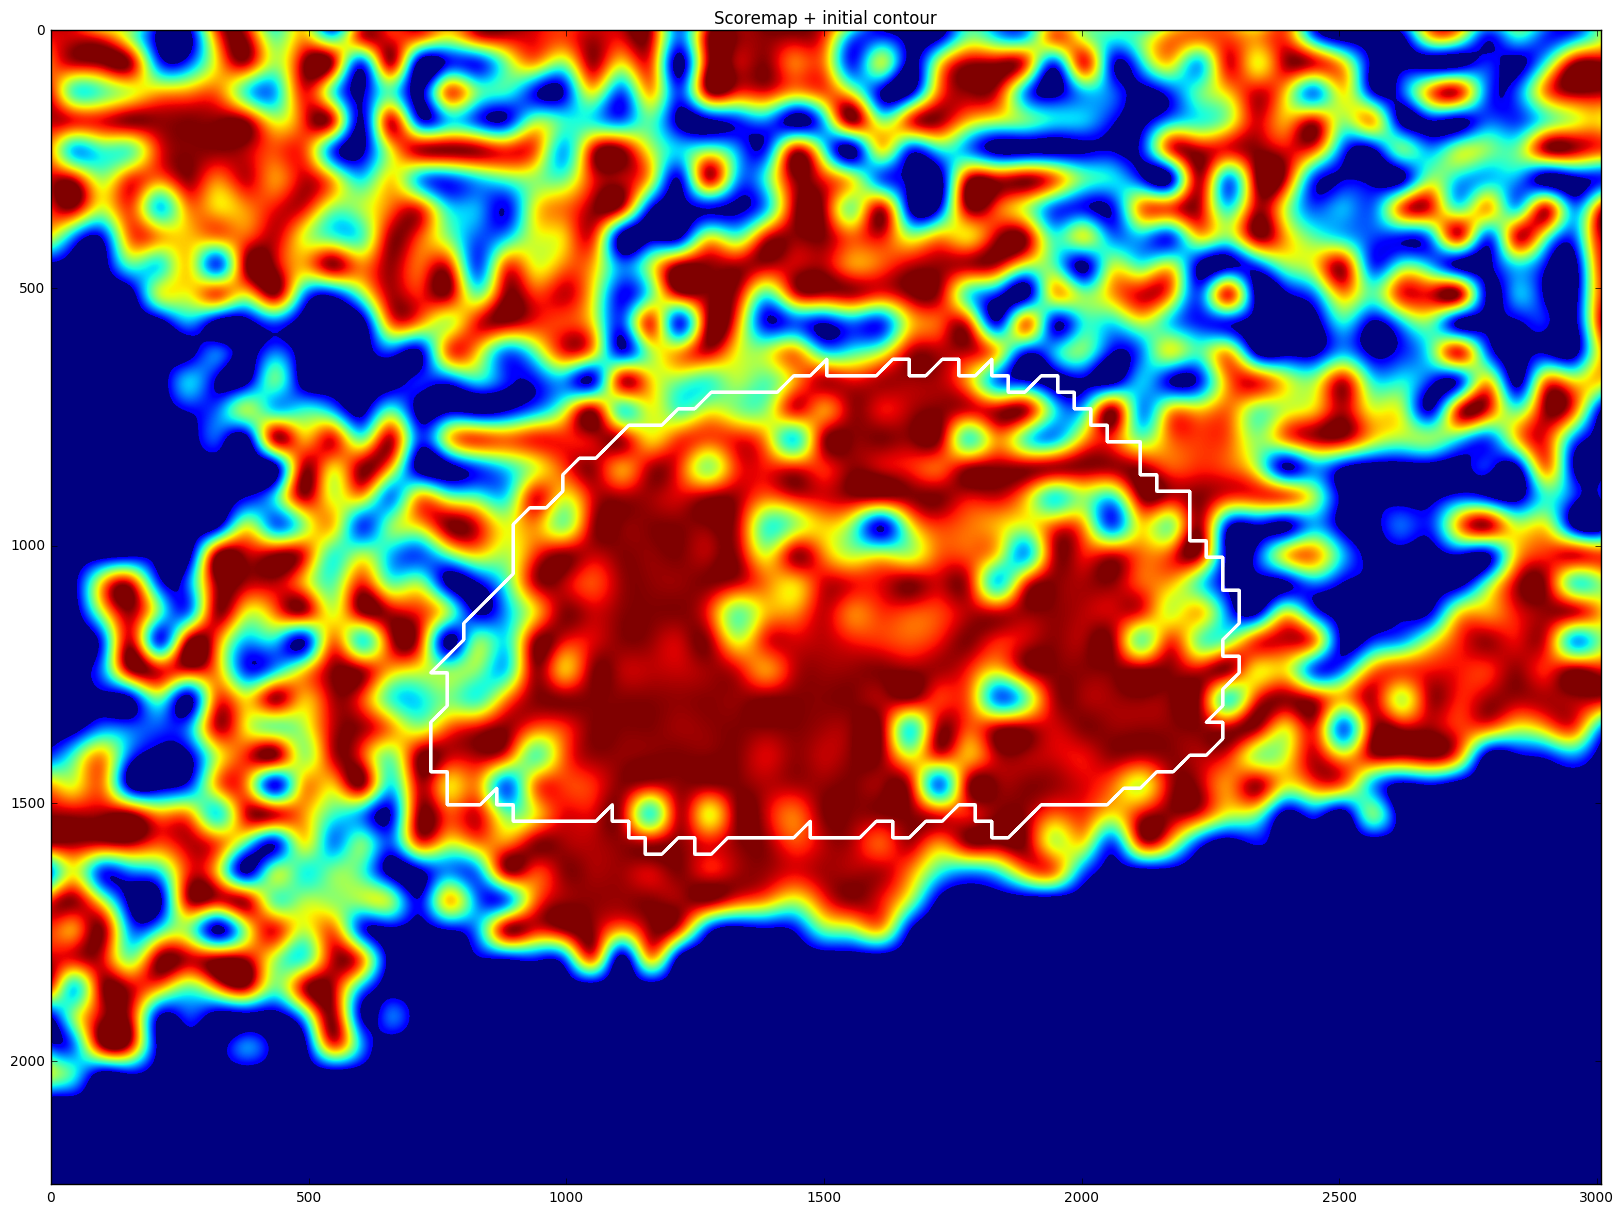

Graph-cut: 327.06 seconds.

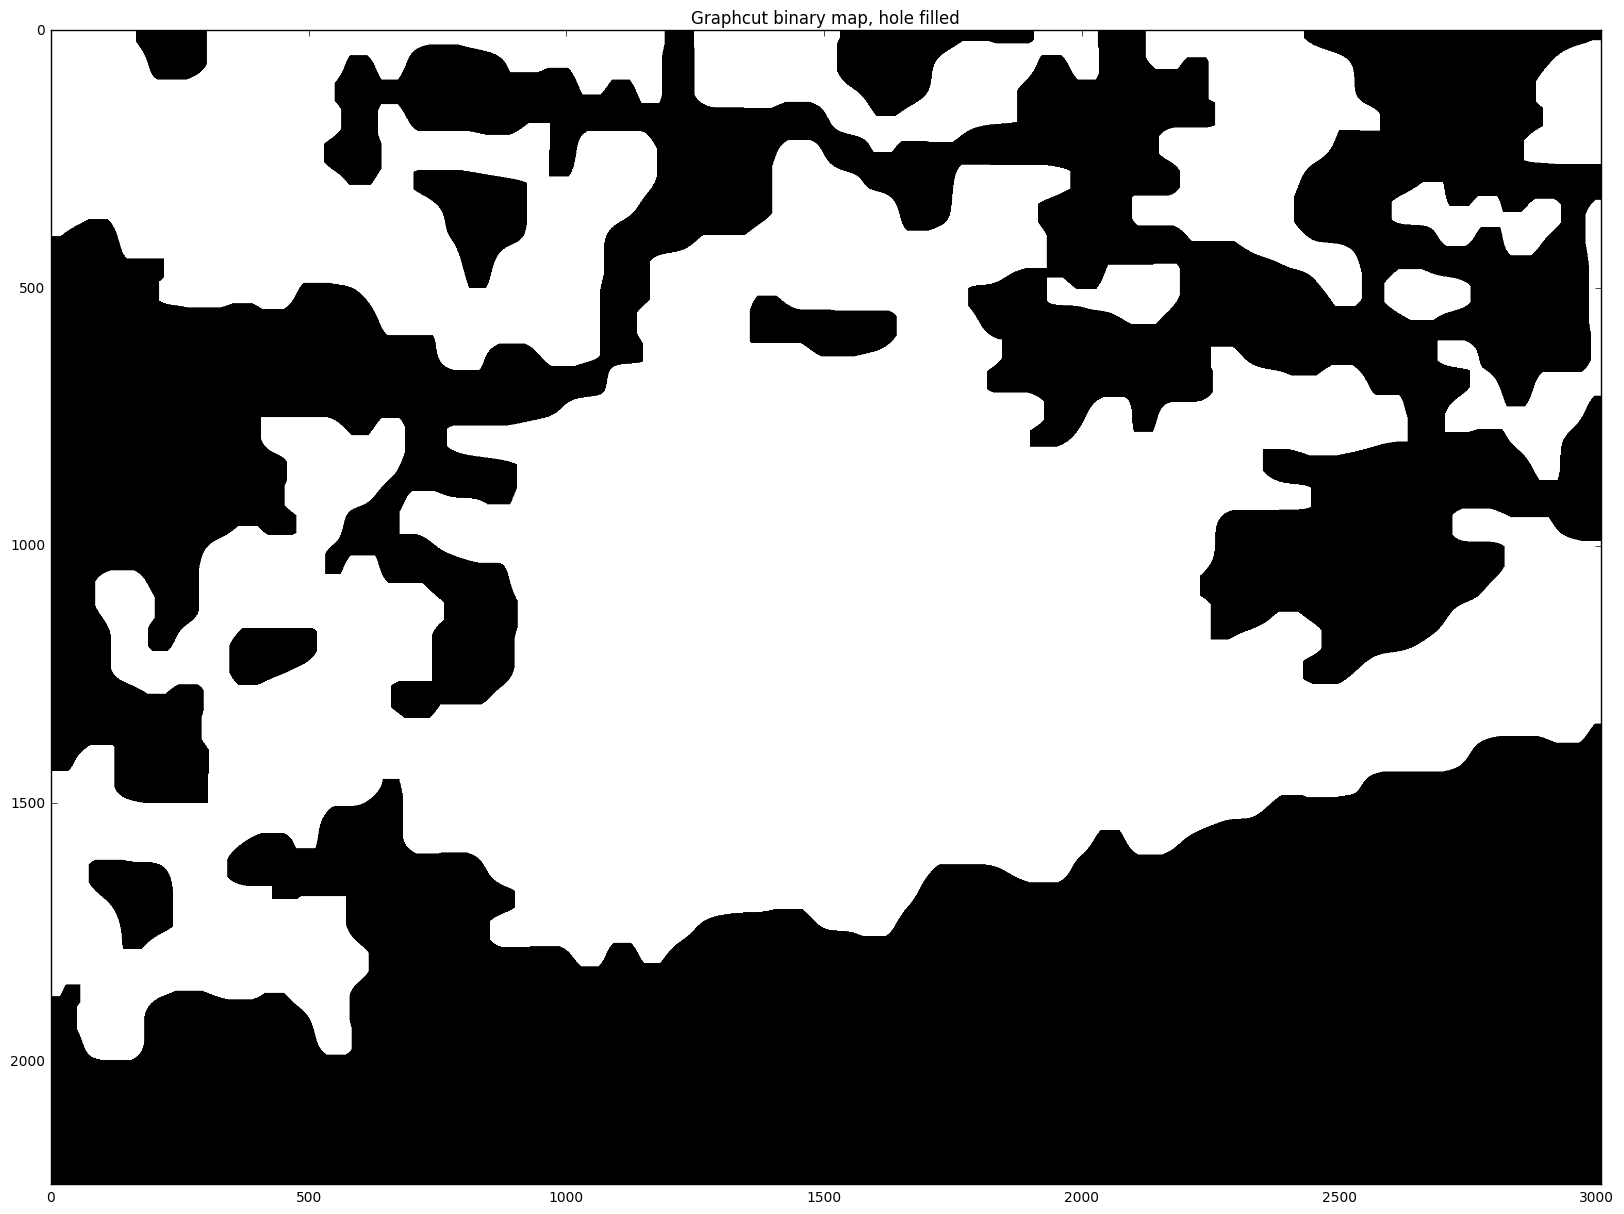

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:135: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 70


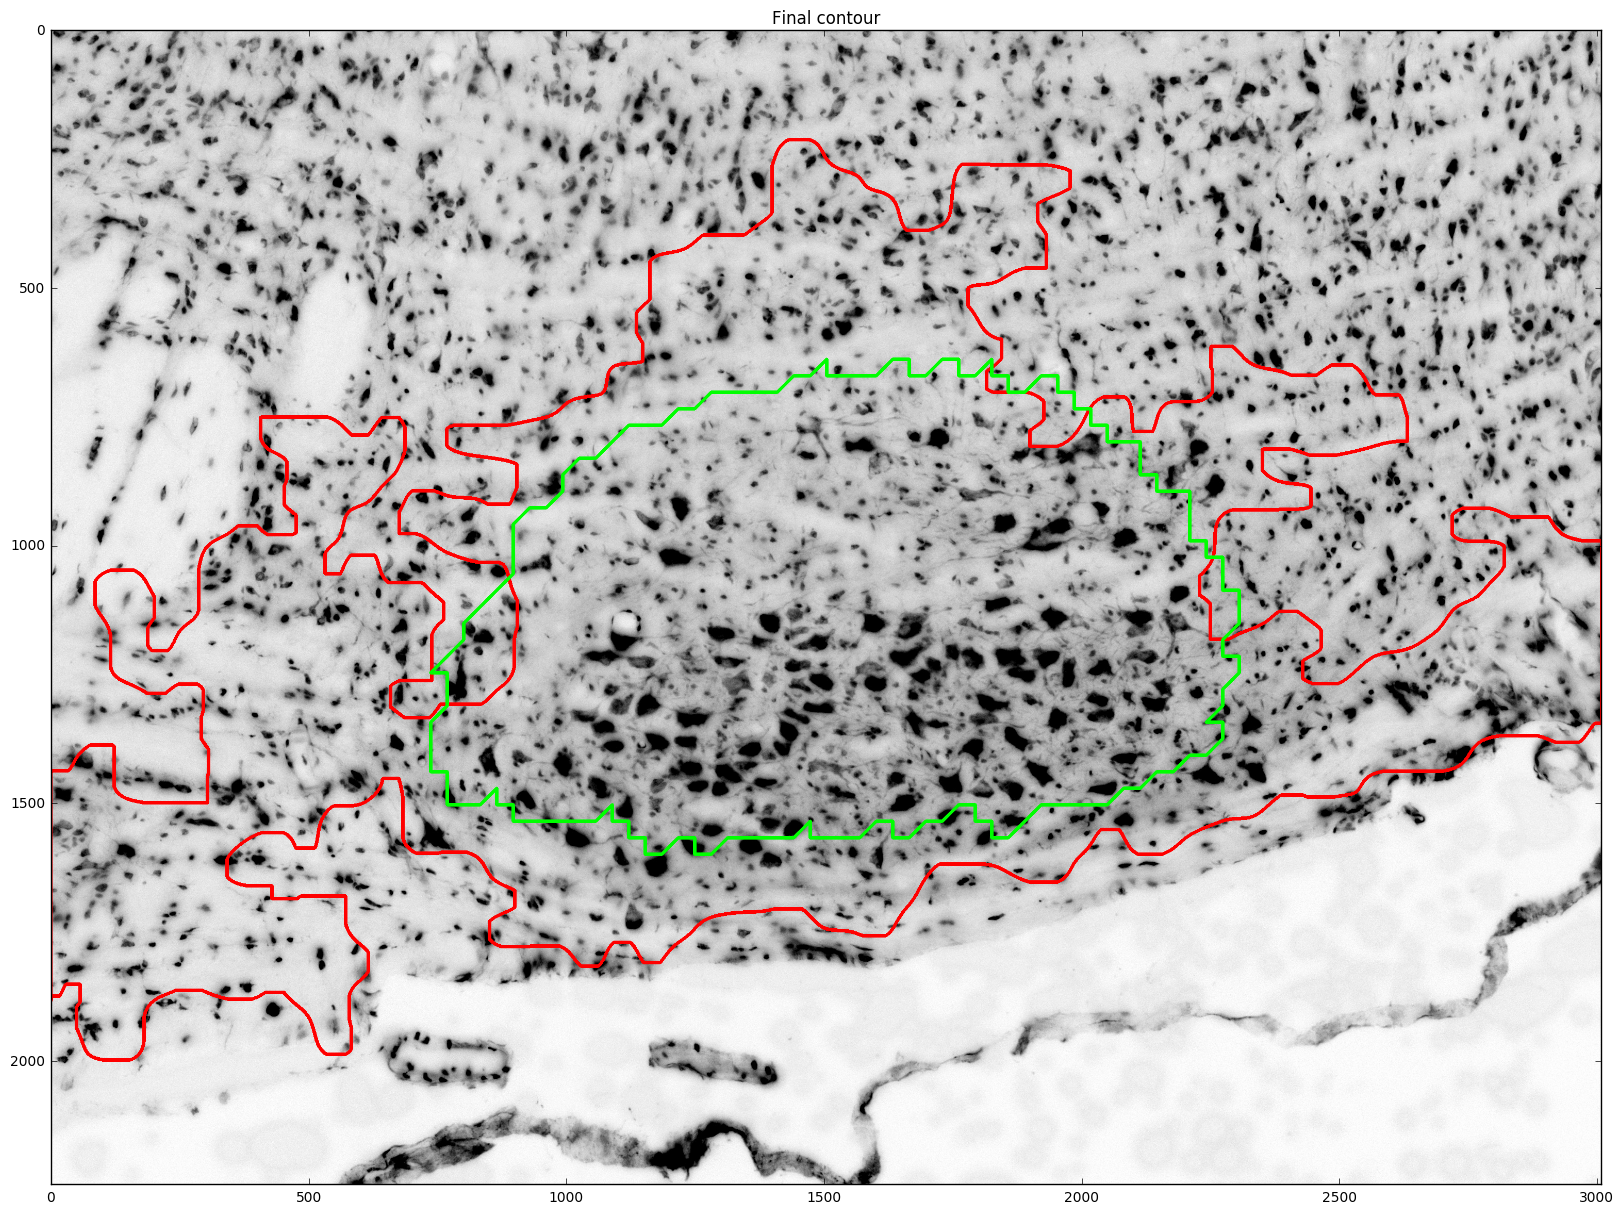

In [15]:
# for sec in range(sec_min, sec_max+1):
# for sec in [(sec_min + sec_max+1)/2]:
for sec in [147]:
    
    print sec
    
    try:
        scoremap = DataManager.load_scoremap(stack=stack, section=sec, label=convert_name_to_unsided(name_sided), 
                                             train_sample_scheme=train_sample_scheme, downscale_factor=1)
    except Exception as e:
        sys.stderr.write(e.message + '\n')
        continue
        
    zl, zh = DataManager.convert_section_to_z(stack=stack, sec=sec, downsample=32)
    z = (zl + zh) / 2
        
#     z = voxel_z_size * (sec - 1) - zmin_vol_f
    
    # Extract initial contour
    nz = np.count_nonzero(vol[..., z])
    if nz < 10:
        sys.stderr.write('Too few voxels %d.\n' % nz)
        continue
    
    init_cnt_xmin, init_cnt_xmax, init_cnt_ymin, init_cnt_ymax = bbox_2d(vol[..., z])

    margin = 20
    crop_xmin = init_cnt_xmin - margin
    crop_ymin = init_cnt_ymin - margin
    crop_xmax = init_cnt_xmax + margin
    crop_ymax = init_cnt_ymax + margin
    print crop_xmin, crop_xmax, crop_ymin, crop_ymax
    # score volume resol. : thumbnail resol

    init_mask = vol[crop_ymin:crop_ymax+1, crop_xmin:crop_xmax+1, z] > .3
    
    contours = find_contour_points(init_mask, sample_every=1, min_length=3)[1]
    assert len(contours) == 1
    init_contour = contours[0]
    
    
    # Crop around initial contour.
    
    img = imread(DataManager.get_image_filepath(stack=stack, section=sec))
    # lossless resol.
    
    img_cropped = img[crop_ymin*32:crop_ymax*32, crop_xmin*32:crop_xmax*32]
    im_cropped_h, im_cropped_w = img_cropped.shape[:2]
    print im_cropped_w, im_cropped_h
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_cropped, cmap=plt.cm.gray)
    plt.title('Image cropped');
    plt.show();

    scoremap_cropped = scoremap[crop_ymin*32:crop_ymax*32, crop_xmin*32:crop_xmax*32]
    
    n = im_cropped_h * im_cropped_w

    import itertools
    node_locations = list(itertools.product(range(im_cropped_h), range(im_cropped_w)))

    scoremap_y_diff = np.diff(scoremap_cropped, axis=0)
    scoremap_x_diff = np.diff(scoremap_cropped, axis=1)
        
    viz = img_as_ubyte(plt.cm.jet(scoremap_cropped)[...,:3])
    cv2.polylines(viz, [init_contour.astype(np.int)*32], isClosed=True, color=(255,255,255,255), thickness=5)
    
    plt.figure(figsize=(20,20));
    plt.imshow(viz)
    plt.title('Scoremap + initial contour');
    plt.show();
    
    # Graph-cut

    t = time.time()
    
    sigma = .3
    sigma_sq = 2*sigma**2

    beta = 1.
    alpha = 1.

    import maxflow

    graph = maxflow.Graph[float](0, 0)

    nodeids = graph.add_grid_nodes(n)

    for node_id in range(n):

        y, x = node_locations[node_id]

        if node_id - 1 > 0 and y > 0 and y < im_cropped_h - 1 and x - 1 > 0 and x - 1 < im_cropped_w - 1:
            weight = np.exp(-scoremap_x_diff[y,x-1]**2/sigma_sq)
            graph.add_edge(node_id, node_id - 1, weight, weight)

        if node_id + 1 < n and y > 0 and y < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
            weight = np.exp(-scoremap_x_diff[y,x]**2/sigma_sq)
            graph.add_edge(node_id, node_id + 1, weight, weight)

        if node_id - im_cropped_w > 0 and y - 1 > 0 and y - 1 < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
            weight = np.exp(-scoremap_y_diff[y-1,x]**2/sigma_sq)
            graph.add_edge(node_id, node_id - im_cropped_w, weight, weight)

        if node_id + im_cropped_w < n and y > 0 and y < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
            weight = np.exp(-scoremap_y_diff[y,x]**2/sigma_sq)
            graph.add_edge(node_id, node_id + im_cropped_w, weight, weight)

        graph.add_tedge(node_id, beta * np.minimum(1./alpha*scoremap_cropped[y,x], 1), 
                        beta * (1-np.minimum(1./alpha*scoremap_cropped[y,x], 1)))

    graph.maxflow();

    node_mincut_labels = graph.get_grid_segments(nodeids)
    mincut_labelmap = ~node_mincut_labels.reshape((im_cropped_h, im_cropped_w))

    sys.stderr.write('Graph-cut: %.2f seconds.' % ( time.time() - t))
    
#     plt.figure(figsize=(20,20));
#     plt.imshow(mincut_labelmap, cmap=plt.cm.gray)
#     plt.title('Graphcut binary map');
#     plt.show();

    mincut_labelmap = remove_small_holes(mincut_labelmap, min_size=10000)
    mincut_labelmap = remove_small_objects(mincut_labelmap, min_size=10000)
    
    plt.figure(figsize=(20,20));
    plt.imshow(mincut_labelmap, cmap=plt.cm.gray)
    plt.title('Graphcut binary map, hole filled');
    plt.show();
    
    conn_map, num_conn = label(mincut_labelmap, return_num=True)
    overlap_with_init_mask = [np.count_nonzero(init_mask[conn_map[::32, ::32] == i]) 
                              for i in range(1, num_conn+1)]
    most_likely_conn_label = np.argsort(overlap_with_init_mask)[-1] + 1
    most_likely_mask = conn_map == most_likely_conn_label

    contours_final = find_contour_points(most_likely_mask, sample_every=1)[1]

#         assert len(contours_final) == 1, 'More than one contour found.'
#         contour_final = contours_final[0]
    
    viz = gray2rgb(img_as_ubyte(img_cropped))
    for contour_final in contours_final:
        cv2.polylines(viz, [contour_final.astype(np.int)], isClosed=True, color=(255,0,0,255), thickness=5)

    cv2.polylines(viz, [init_contour.astype(np.int)*32], isClosed=True, color=(0,255,0,255), thickness=5)
        
    plt.figure(figsize=(20,20));
    plt.imshow(viz);
    plt.title('Final contour');
    plt.show();
    
    #     plt.figure(figsize=(20,20));
    #     plt.imshow(alpha_blending(img_cropped, gray2rgb((~mincut_labelmap)*255), 0.5, 0.5))
    #     plt.title('Binary overlayed');
    #     plt.show();
    
    imsave(FITTED_CONTOUR_DIR + '/%(fn)s_%(name_sided)s_snakeViz.jpg' % dict(fn=sec2fn[sec], name_sided=name_sided), viz)